<b><font size=20, color='#A020F0'>Class Notebook 6</font></b>

## Welcome to your sixth in-class jupyter notebook activity!
In this notebook you'll get more practice with xESMF.

---

<b><font color='red'>Due Date: 11 November 2024 @ 9 am</font></b><br>

<b>How you will turn in this assignment</b><br> When you are ready to turn in your notebook, do the following:
1. Save your notebook and make sure your results are visible (cells have been executed)
2. Open a terminal and navigate to your local `aos573_completed_assignments` repository
3. Move your completed in-class notebook into your `Class_Notebooks` directory
4. `add` and `commit` your completed notebook
5. Finally, `push` your changes to your remote `aos573_completed_assignments` repository: `git push finished_work main` (you'll need to enter your username and personal access token)
6. <b><font color='red'>REMINDER: DO NOT TRACK OR PUSH THE DATA USED IN THE NOTEBOOK OR THE WEIGHT FILES CREATED DURING REGRIDDING</font></b>

---

## 1. Reading in and exploring your data
In this notebook you'll be using some output from the [Tropical Rainfall Measuring Mission](https://gpm.nasa.gov/missions/trmm) (TRMM). To keep the regridding from getting out of hand I've provided you with a single 2D precipitation field from 31 July 2016. Read in the data in the file `trmm.2016-07-31T12.nc` (it's in the data folder in the InClass directory of our course repo) and take a look at the contents. 

Go through the typical questions to help you become familiar with your data: What variables exist in the dataset? What are the units? What are the latitude and longitude ranges? What is the resolution? There's no need to write these down as answers in the notebook, but make sure you have a sense of what you're working with before you proceed.

In [74]:
import xesmf as xe
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.transforms import Bbox

In [46]:
ds=xr.open_dataset('~/aos573_f24/InClass/data/trmm.2016-07-31T12.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 240, lon: 1440, lat_b: 241, lon_b: 1441)
Coordinates:
  * lat      (lat) float32 -29.88 -29.62 -29.38 -29.12 ... 29.38 29.62 29.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    time     datetime64[ns] ...
  * lat_b    (lat_b) float64 -30.0 -29.75 -29.5 -29.25 ... 29.25 29.5 29.75 30.0
  * lon_b    (lon_b) float64 -180.0 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
Data variables:
    precip   (lat, lon) float32 ...
Attributes:
    history:  Mon Nov  1 19:26:31 2021: ncks -F -d time,1,,2 trmm.4x.30ns.199...
    NCO:      netCDF Operators version 5.0.0 (Homepage = http://nco.sf.net, C...

---

## 2. Regridding with xesmf
In this section you'll get a chance to upscale your data (go from high resolution to lower resolution). You'll use two different regridding algorithms and compare them to your original data at the end. We'll go through this step-by-step:

### 2.1 Subset the TRMM precip data
Extract the precip data at every 2.5˚ in latitude and 2.5˚ in longitude. 

In [47]:
ds_t = ds.thin(10)

### 2.2 Create a target grid
Using the latitudes and longitudes from your _extracted_ data, create a target grid for regridding. In addition to the latitudes and longitudes, this target grid must have latitude and longitude bounds (so you can do conservative regridding). You will need to create these bounds yourself. The bounds should be halfway between each grid point, and each 1D list of latitude and longitude bounds should be 1 point larger than the number of latitudes and longitudes, respectively. If you get stuck, look at how lat_b and lon_b are structured relative to lat and lon in the data; this should help.

In [48]:
# target_grid=xe.util.grid_global(1.0, 0.5)
# target_grid


lat_b = ds_t.lat.values - 1.25
lat_b = np.concatenate((lat_b, [lat_b[-1] + 1.25]))
lon_b = ds_t.lon.values - 1.25
lon_b = np.concatenate((lon_b, [lon_b[-1] + 1.25]))

ds_t['lat_b'] = lat_b
ds_t['lon_b'] = lon_b

ds_t.lon_b.values

array([-181.125, -178.625, -176.125, -173.625, -171.125, -168.625,
       -166.125, -163.625, -161.125, -158.625, -156.125, -153.625,
       -151.125, -148.625, -146.125, -143.625, -141.125, -138.625,
       -136.125, -133.625, -131.125, -128.625, -126.125, -123.625,
       -121.125, -118.625, -116.125, -113.625, -111.125, -108.625,
       -106.125, -103.625, -101.125,  -98.625,  -96.125,  -93.625,
        -91.125,  -88.625,  -86.125,  -83.625,  -81.125,  -78.625,
        -76.125,  -73.625,  -71.125,  -68.625,  -66.125,  -63.625,
        -61.125,  -58.625,  -56.125,  -53.625,  -51.125,  -48.625,
        -46.125,  -43.625,  -41.125,  -38.625,  -36.125,  -33.625,
        -31.125,  -28.625,  -26.125,  -23.625,  -21.125,  -18.625,
        -16.125,  -13.625,  -11.125,   -8.625,   -6.125,   -3.625,
         -1.125,    1.375,    3.875,    6.375,    8.875,   11.375,
         13.875,   16.375,   18.875,   21.375,   23.875,   26.375,
         28.875,   31.375,   33.875,   36.375,   38.875,   41.

### 2.3 Set up the regridders
Set up two regridders--one for bilinear regridding and one for conservative regridding

In [49]:
regridder_b=xe.Regridder(ds, ds_t, method='bilinear',periodic=True,reuse_weights=False)
regridder_c=xe.Regridder(ds, ds_t, method='conservative',periodic=True,reuse_weights=False)

### 2.4 Regrid
Apply the regridders to the precipitation data

In [50]:
ds_bre = regridder_b(ds)
ds_cre = regridder_c(ds)

### 2.5 Compare your results

#### 2.5.1 Global sums
Compare the global sums of your regridded fields and your subsetted precip field from Q2.1 to the global sum of the original data. I have set up the code to compute the sum of the original data, as it needs to be scaled to be comparable to the regridded fields and it also needs to exclude a few points that are not on the new grids.

Which regridding algorithm provides results that are closest to the original data? What regridding algorithm is your subsetted data from Q2.1 most similar to, and why do you suppose that this is the case?

In [51]:
original_grid_precip_sum=0.01*ds.precip[:-4,:-4].sum()
print(original_grid_precip_sum)
print(ds_bre.precip.sum())
print(ds_cre.precip.sum())

<xarray.DataArray 'precip' ()>
array(465.52867187)
Coordinates:
    time     datetime64[ns] ...
<xarray.DataArray 'precip' ()>
array(488.20538, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-07-31T12:00:00
<xarray.DataArray 'precip' ()>
array(465.13885, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-07-31T12:00:00


The conservative regridding was the closest to the original data.

#### 2.5.2 Plotting
Make a 2x1 set of 2D pcolormesh plots showing the spatial difference between the original data and the conservative and bilinear regridding algorithms. To directly compare the original data to the regridded data, you'll need to bin the original data so that it is on the same grid as the regridded data. I have set up some code for you below so that you do not need to do the binning yourself. When plotting, if matplotlib yells at you about dimensions, try plotting only the values of the data.

Additional plotting parameters:
1. Use a cartopy map projection that is good for showing the tropics
2. Add a land outline to the maps
3. Choose an appropriate colorbar for your maps
4. Label your colorbar and include a title for each subplot

In [61]:
precip_binned=0.01*ds.precip.groupby_bins(group=ds.lon, bins=lon_b).sum().groupby_bins(group=ds.lat, bins=lat_b).sum()

In [78]:
bilin = precip_binned-ds_bre
cons = precip_binned-ds_cre
cons

<xarray.Dataset>
Dimensions:   (lat_b: 241, lon_b: 1441, lat: 24, lon: 144, lon_bins: 144,
               lat_bins: 24)
Coordinates:
    time      datetime64[ns] 2016-07-31T12:00:00
  * lat_b     (lat_b) float64 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
  * lon_b     (lon_b) float64 -180.0 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
  * lat       (lat) float32 -29.88 -27.38 -24.88 -22.38 ... 22.62 25.12 27.62
  * lon       (lon) float32 -179.9 -177.4 -174.9 -172.4 ... 172.6 175.1 177.6
  * lon_bins  (lon_bins) object (-181.125, -178.625] ... (176.375, 177.625]
  * lat_bins  (lat_bins) object (-31.125, -28.625] ... (26.375, 27.625]
Data variables:
    precip    (lat_bins, lon_bins, lat, lon) float32 0.0 -0.007543 ... -0.02577

ValueError: For X (145) and Y (25) with flat shading, A should have shape (24, 144, 3) or (24, 144, 4) or (24, 144) or (3456,), not (24, 144, 24, 144)

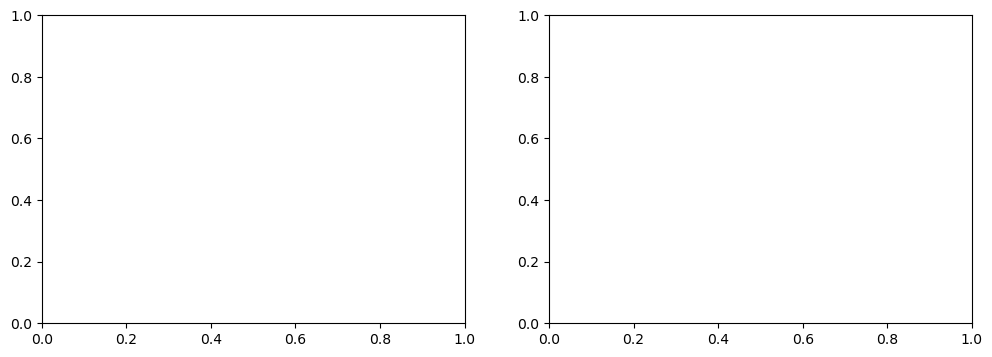

In [96]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

c1=ax[0].pcolormesh(bilin.lon,bilin.lat,bilin['precip'].values,shading='auto')
# ax[0].set_title('')
# plt.colorbar(c1,ax=ax[0])

c2=ax[1].pcolormesh(cons.lon,cons.lat,cons.precip.values,shading='auto')
# ax[1].set_title('')
# plt.colorbar(c2,ax=ax[1])

AttributeError: 'numpy.ndarray' object has no attribute 'pcolormesh'

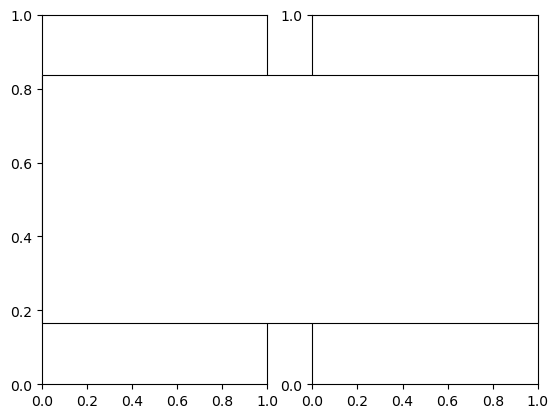

In [98]:
fig, axs = plt.subplots(1,2)

axs0=fig.add_subplot(111,projection=ccrs.PlateCarree())
axs1.coastlines()
bilin.precip.values.pcolormesh(axs=axs1)

axs2=fig.add_subplot(cons.values,projection=ccrs.PlateCarree())
axs2.coastlines()

---